In [1]:
import plumed
import matplotlib.pyplot as plt
import os
import MDAnalysis
import numpy as np
import math

In [2]:
# set working directory for all future cells
os.chdir("/Users/max/build/PLUMED/plumed-masterclass/masterclass-21-4")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()

/Users/max/build/PLUMED/plumed-masterclass/masterclass-21-4


'/Users/max/build/PLUMED/plumed-masterclass/masterclass-21-4'

In [3]:
%%bash
# Exercise 1
# create directory for this exercise
mkdir Exercise-1; cd Exercise-1

# prepare PLUMED input file for analysis
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Print the two collective variables on COLVAR file every step
PRINT ARG=phi,psi FILE=COLVAR STRIDE=1 
EOF

# run MD from conformation A
mkdir run_A; cd run_A
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 10000000
# and analyze
plumed driver --plumed ../plumed.dat --mf_xtc traj_comp.xtc
cd ../
# run MD from conformation B
mkdir run_B; cd run_B
gmx mdrun -s ../../data/diala/topolB.tpr -nsteps 10000000
# and analyze
plumed driver --plumed ../plumed.dat --mf_xtc traj_comp.xtc


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: ../plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUM

mkdir: Exercise-1: File exists
mkdir: run_A: File exists
mkdir: run_B: File exists


Std phi run_A: 0.5532909817219714
Std phi run_B: 0.1317100551971834


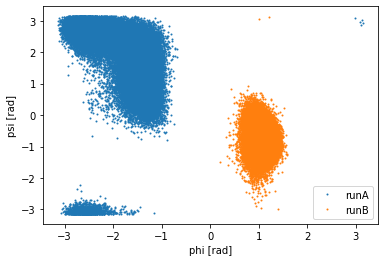

In [4]:
# import PLUMED COLVAR files into pandas datasets
dataA=plumed.read_as_pandas("Exercise-1/run_A/COLVAR")
dataB=plumed.read_as_pandas("Exercise-1/run_B/COLVAR")
# plot phi vs psi
plt.plot(dataA["phi"],dataA["psi"],'o',ms=1, label="runA")
plt.plot(dataB["phi"],dataB["psi"],'o',ms=1, label="runB")
# x-y axis labels
plt.xlabel("phi [rad]")
plt.ylabel("psi [rad]")
plt.legend()
# calculate Gaussian sigma
print("Std phi run_A:",np.std(dataA["phi"]))
print("Std phi run_B:",np.std(dataB["phi"]))

In [5]:
%%bash
# Exercise 2
# create directory for this exercise
mkdir Exercise-2; cd Exercise-2
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in phi
metad: METAD ARG=phi ...
   # Deposit a Gaussian every 500 time steps, with initial height 
   # equal to 1.2 kJ/mol and bias factor equal to 8 
   PACE=500 HEIGHT=1.2 BIASFACTOR=8 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=HILLS GRID_MIN=-pi GRID_MAX=pi 
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi FILE=COLVAR STRIDE=10   
EOF

# run simulation
gmx mdrun -s ../data/diala/topolA.tpr -nsteps 10000000 -plumed plumed.dat

mkdir: Exercise-2: File exists


Text(0, 0.5, 'phi [rad]')

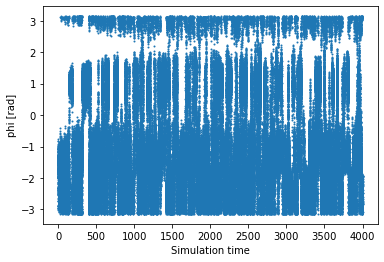

In [6]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-2/COLVAR")
# plot phi during simulation (first 200k points)
plt.plot(data["time"][:200000],data["phi"][:200000],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("phi [rad]")

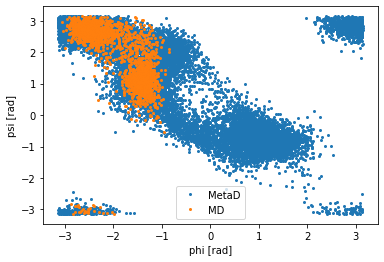

In [7]:
# plot phi vs psi
# plot phi vs psi
plt.plot(data["phi"][::50],data["psi"][::50],'o', ms=2,   label="MetaD")
plt.plot(dataA["phi"][::50],dataA["psi"][::50],'o', ms=2, label="MD")
# x-y axis labels
plt.xlabel("phi [rad]")
plt.ylabel("psi [rad]")
plt.legend()

In [8]:
%%bash
# compute free energy as a function of simulation time
cd Exercise-2
plumed sum_hills --hills HILLS --stride 200 --mintozero

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: F

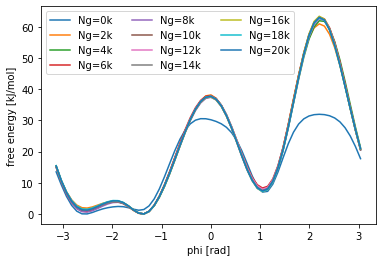

In [9]:
# plot free energy as a function of simulation time
for i in range(0,101,10):   
 # import fes file into pandas dataset
 data=plumed.read_as_pandas("Exercise-2/fes_"+str(i)+".dat")
 # plot fes
 plt.plot(data["phi"],data["file.free"], label="Ng="+str(int(2*i/10))+"k") 
# labels
plt.xlabel("phi [rad]")
plt.ylabel("free energy [kJ/mol]")
plt.legend(ncol=3)

Text(0, 0.5, 'DeltaF [kJ/mol]')

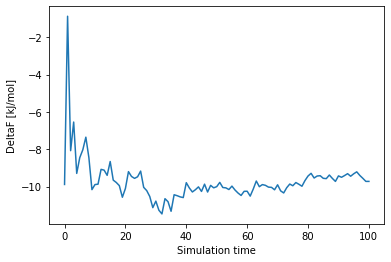

In [10]:
# calculate free-energy difference
DeltaF=[]; kbt=2.494339
# cycle on free-energy profiles
for i in range(0,101):   
 # import fes file into pandas dataset
 data=plumed.read_as_pandas("Exercise-2/fes_"+str(i)+".dat")
 # find minimum value of fes
 minf = min(data["file.free"])
 # plot fes
 F0=0.0; F1=0.0
 for j in range(0, len(data["phi"])):
     phi = data["phi"][j]
     # calculate probability
     p = math.exp((-data["file.free"][j]+minf)/kbt)
     # integrate in the two basins
     if(-3<=phi<=-1):   F0 += p
     if(0.5<=phi<=1.5): F1 += p
 # calculate free energy difference and add to list
 DeltaF.append(-kbt*math.log(F0/F1))         
# plot
plt.plot(DeltaF) 
# labels
plt.xlabel("Simulation time")
plt.ylabel("DeltaF [kJ/mol]")

In [11]:
%%bash
# Exercise 3
# create directory for this exercise
mkdir Exercise-3; cd Exercise-3

# prepare PLUMED input file for reweighting
cat > "plumed_reweight.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in phi
metad: METAD ARG=phi ...
   # Deposit a Gaussian every 10000000 time steps (never!), with initial height equal to 0.0 kJ/mol 
   PACE=10000000 HEIGHT=0.0 BIASFACTOR=8# <- this is the new stuff! 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=../Exercise-2/HILLS GRID_MIN=-pi GRID_MAX=pi
   # Say that METAD should be restarting (= reading an existing HILLS file) 
   RESTART=YES # <- this is the new stuff! 
...

# Use the metadynamics bias as argument
as: REWEIGHT_BIAS ARG=metad.bias 
# Calculate histograms of phi and psi dihedrals every 50 steps
# using the weights obtained from the metadynamics bias potentials (umbrella-sampling-like reweighting)
# Look at the manual to understand the parameters of the HISTOGRAM action!
hhphi: HISTOGRAM ARG=phi STRIDE=50 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=50 BANDWIDTH=0.05 LOGWEIGHTS=as 
hhpsi: HISTOGRAM ARG=psi STRIDE=50 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=50 BANDWIDTH=0.05 LOGWEIGHTS=as 
# Convert histograms h(s) to free energies F(s) = -kBT * log(h(s))
ffphi: CONVERT_TO_FES GRID=hhphi 
ffpsi: CONVERT_TO_FES GRID=hhpsi 
# Print out the free energies F(s) to file once the entire trajectory is processed
DUMPGRID GRID=ffphi FILE=ffphi.dat 
DUMPGRID GRID=ffpsi FILE=ffpsi.dat 

# Print out the values of phi, psi and the metadynamics bias potential
# Make sure you print out the 3 variables in the specified order at every step
PRINT ARG=phi,psi,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1 # <- also change this one!
EOF

# analyze with PLUMED driver
plumed driver --mf_xtc ../Exercise-2/traj_comp.xtc --plumed plumed_reweight.dat --kt 2.494339


DRIVER: Found molfile format trajectory xtc with name ../Exercise-2/traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between at

mkdir: Exercise-3: File exists


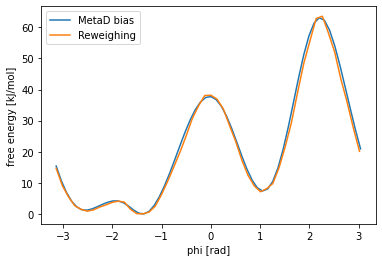

In [12]:
# now compare free energy from metadynamics bias and reweighting
data_b=plumed.read_as_pandas("Exercise-2/fes_100.dat")
data_r=plumed.read_as_pandas("Exercise-3/ffphi.dat")

# plot free energies
plt.plot(data_b["phi"],data_b["file.free"],label="MetaD bias")
plt.plot(data_r["phi"],data_r["ffphi"]-min(data_r["ffphi"]),label="Reweighing")
# x-y axis labels
plt.xlabel("phi [rad]")
plt.ylabel("free energy [kJ/mol]")
plt.legend()

In [13]:
%%bash
# Exercise 4
# create directory for this exercise
mkdir Exercise-4; cd Exercise-4

# create phi.weight file with phi and weight from COLVAR_REWEIGHT
# find maximum of bias
bmax=`sort -n -k 4 ../Exercise-3/COLVAR_REWEIGHT  | tail -n 1 | awk '{print $4}'`
# create phi.weight file
awk '{if($1!="#!") print $2,exp(($4-bm)/2.494339)}' bm=$bmax ../Exercise-3/COLVAR_REWEIGHT > phi.weight

# and now do block analysis with block sizes from 1 to 1000 (every 10)
# create PLUMED-like header for output file
echo "#! FIELDS bsize err" > err.blocks
for i in `seq 1 10 1000`
do
 # run the python script
 python ../data/do_block_fes.py phi.weight 1 -3.141593 3.141593 50 2.494339 $i
 # calculate average error along the free-energy profile
 awk 'BEGIN{tot=0}{tot+=$3}END{print i,tot/NR}' i=$i fes.$i.dat
done >> err.blocks

mkdir: Exercise-4: File exists


Text(0, 0.5, 'Average error on free-energy profile [kJ/mol]')

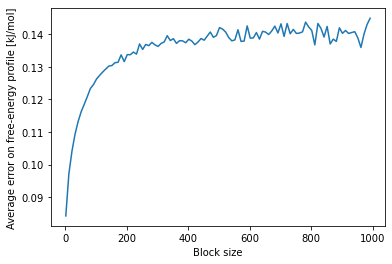

In [14]:
# import err.blocks file into pandas dataset
data=plumed.read_as_pandas("Exercise-4/err.blocks")
# plot error as a function of block size
plt.plot(data["bsize"],data["err"])
# x-y axis labels
plt.xlabel("Block size")
plt.ylabel("Average error on free-energy profile [kJ/mol]")

In [15]:
%%bash
# Exercise 5 - bad CV
# create directory for this exercise
mkdir -p Exercise-5/bad_CV; cd Exercise-5/bad_CV
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in psi
metad: METAD ARG=psi ...
   # Deposit a Gaussian every 500 time steps, with initial height 
   # equal to 1.2 kJ/mol and bias factor equal to 8 
   PACE=500 HEIGHT=1.2 BIASFACTOR=8 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=HILLS GRID_MIN=-pi GRID_MAX=pi 
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi FILE=COLVAR STRIDE=10   
EOF

# run simulation
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 10000000 -plumed plumed.dat

Text(0, 0.5, 'phi [rad]')

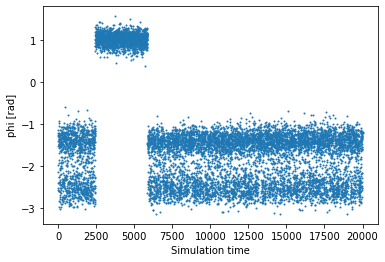

In [16]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-5/bad_CV/COLVAR")
# plot phi during simulation
plt.plot(data["time"][::100],data["phi"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("phi [rad]")

In [17]:
%%bash
# Calculate error in free-energy
cd Exercise-5/bad_CV

# prepare PLUMED input file for reweighting
cat > "plumed_reweight.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in phi
metad: METAD ARG=psi ...
   # Deposit a Gaussian every 10000000 time steps (never!), with initial height equal to 0.0 kJ/mol 
   PACE=10000000 HEIGHT=0.0 BIASFACTOR=8# <- this is the new stuff! 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=HILLS GRID_MIN=-pi GRID_MAX=pi
   # Say that METAD should be restarting (= reading an existing HILLS file) 
   RESTART=YES # <- this is the new stuff! 
...

# Print out the values of phi, psi and the metadynamics bias potential
PRINT ARG=phi,psi,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1 # <- also change this one!
EOF

# analyze with PLUMED driver
plumed driver --mf_xtc traj_comp.xtc --plumed plumed_reweight.dat --kt 2.494339

# create phi.weight file with phi and weight from COLVAR_REWEIGHT
# find maximum of bias
bmax=`sort -n -k 4 COLVAR_REWEIGHT  | tail -n 1 | awk '{print $4}'`
# create phi.weight file
awk '{if($1!="#!") print $2,exp(($4-bm)/2.494339)}' bm=$bmax COLVAR_REWEIGHT > phi.weight

# and now do block analysis with block sizes from 1 to 5000 (every 50)
# create PLUMED-like header for output file
echo "#! FIELDS bsize err" > err.blocks
for i in `seq 1 50 5000`
do
 # run the python script
 python ../../data/do_block_fes.py phi.weight 1 -3.141593 3.141593 50 2.494339 $i
 # calculate average error along the free-energy profile (remove Inf)
 grep -v Inf fes.$i.dat | awk 'BEGIN{tot=0}{tot+=$3}END{print i,tot/NR}' i=$i
done >> err.blocks


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 1

Text(0, 0.5, 'Average error on free-energy profile [kJ/mol]')

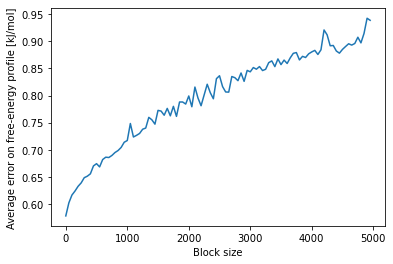

In [18]:
# import err.blocks file into pandas dataset
data=plumed.read_as_pandas("Exercise-5/bad_CV/err.blocks")
# plot error as a function of block size
plt.plot(data["bsize"],data["err"])
# x-y axis labels
plt.xlabel("Block size")
plt.ylabel("Average error on free-energy profile [kJ/mol]")

In [19]:
%%bash
# Exercise 5 - good CV
# create directory for this exercise
mkdir -p Exercise-5/good_CV; cd Exercise-5/good_CV
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: CUSTOM ARG=rA,rB VAR=x,y PERIODIC=NO FUNC=(1.0*exp(-169.2*x*x)+2.0*exp(-169.2*y*y))/(exp(-169.2*x*x)+exp(-169.2*y*y))
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
  # Deposit a Gaussian every 500 time steps, with initial height
  # equal to 1.2 kJ/mol and bias factor equal to 8
  PACE=500 HEIGHT=1.2 BIASFACTOR=8
  # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run
  # try 1/2 or 1/3 of the estimated fluctuations
  SIGMA=0.05
  # Gaussians will be written to file and also stored on grid
  FILE=HILLS GRID_MIN=0 GRID_MAX=3
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi,s FILE=COLVAR STRIDE=10
EOF

# run simulation
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 10000000 -plumed plumed.dat

Text(0, 0.5, 's')

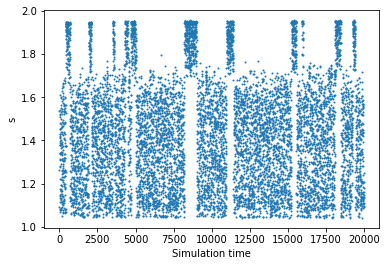

In [20]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-5/good_CV/COLVAR")
# plot the s-path variable during the simulation
plt.plot(data["time"][::100],data["s"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("s")

Text(0, 0.5, 'phi [rad]')

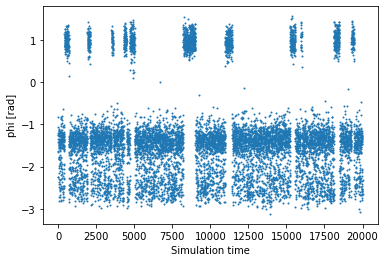

In [21]:
# plot phi during the simulation
plt.plot(data["time"][::100],data["phi"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("phi [rad]")

In [22]:
%%bash
# Calculate error in free-energy
cd Exercise-5/good_CV

# prepare PLUMED input file for reweighting
cat > "plumed_reweight.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: CUSTOM ARG=rA,rB VAR=x,y PERIODIC=NO FUNC=(1.0*exp(-169.2*x*x)+2.0*exp(-169.2*y*y))/(exp(-169.2*x*x)+exp(-169.2*y*y))
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
   # Deposit a Gaussian every 10000000 time steps (never!), with initial height equal to 0.0 kJ/mol 
   PACE=10000000 HEIGHT=0.0 BIASFACTOR=8# <- this is the new stuff! 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.05
   # Gaussians will be written to file and also stored on grid
   FILE=HILLS GRID_MIN=0 GRID_MAX=3
   # Say that METAD should be restarting (= reading an existing HILLS file) 
   RESTART=YES # <- this is the new stuff! 
...
# Print out the values of phi, psi and the metadynamics bias potential
PRINT ARG=phi,psi,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1 # <- also change this one!
EOF

# analyze with PLUMED driver
plumed driver --mf_xtc traj_comp.xtc --plumed plumed_reweight.dat --kt 2.494339

# create phi.weight file with phi and weight from COLVAR_REWEIGHT
# find maximum of bias
bmax=`sort -n -k 4 COLVAR_REWEIGHT  | tail -n 1 | awk '{print $4}'`
# create phi.weight file
awk '{if($1!="#!") print $2,exp(($4-bm)/2.494339)}' bm=$bmax COLVAR_REWEIGHT > phi.weight

# and now do block analysis with block sizes from 1 to 5000 (every 50)
# create PLUMED-like header for output file
echo "#! FIELDS bsize err" > err.blocks
for i in `seq 1 50 5000`
do
 # run the python script
 python ../../data/do_block_fes.py phi.weight 1 -3.141593 3.141593 50 2.494339 $i
 # calculate average error along the free-energy profile (remove Inf)
 grep -v Inf fes.$i.dat | awk 'BEGIN{tot=0}{tot+=$3}END{print i,tot/NR}' i=$i
done >> err.blocks


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 1

Text(0, 0.5, 'Average error on free-energy profile [kJ/mol]')

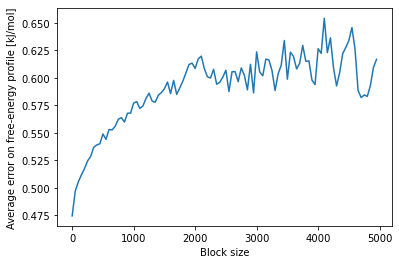

In [23]:
# import err.blocks file into pandas dataset
data=plumed.read_as_pandas("Exercise-5/good_CV/err.blocks")
# plot error as a function of block size
plt.plot(data["bsize"],data["err"])
# x-y axis labels
plt.xlabel("Block size")
plt.ylabel("Average error on free-energy profile [kJ/mol]")

In [24]:
%%bash
# Exercise 6
# create directory for this exercise
mkdir Exercise-6; cd Exercise-6
# create PLUMED input file
cat > "plumed.dat" << EOF
# define CVs - RMSDs from the two reference conformations
rmsd_A: RMSD REFERENCE=state_A-Ca.pdb TYPE=OPTIMAL
rmsd_B: RMSD REFERENCE=state_B-Ca.pdb TYPE=OPTIMAL
# 2D metadynamics
metad: METAD ARG=rmsd_A,rmsd_B ...
    # Gaussian pace, height, and biasfactor
    PACE=500 HEIGHT=1.2 BIASFACTOR=60
    # Sigma and hills file
    SIGMA=0.05,0.05 FILE=HILLS
    # Grid for computational efficiency
    GRID_MIN=0.0,0.0 GRID_MAX=5.0,5.0
...
# print info to COLVAR
PRINT ARG=rmsd_A,rmsd_B FILE=COLVAR STRIDE=500  
EOF

# run simulation
#gmx mdrun -plumed plumed.dat -ntomp 4 -noddcheck -s ../data/RfaH-CTD/topol.tpr

# calculate free energy
plumed sum_hills --hills HILLS --mintozero

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: F

mkdir: Exercise-6: File exists


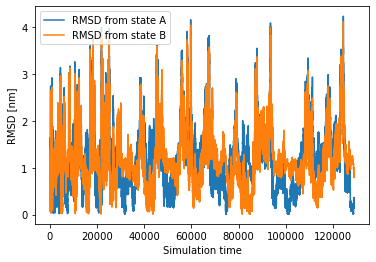

In [25]:
# analyze behavior of CVs
data=plumed.read_as_pandas("Exercise-6/COLVAR")
# plot time serie of the two CVs
plt.plot(data["time"],data["rmsd_A"], label="RMSD from state A")
plt.plot(data["time"],data["rmsd_B"], label="RMSD from state B")
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("RMSD [nm]")
plt.legend()

Text(0, 0.5, 'RMSD from state B [nm]')

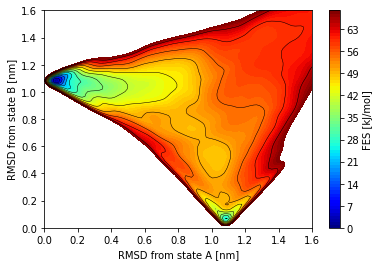

In [26]:
# plot final fes
data=plumed.read_as_pandas("Exercise-6/fes.dat")
# get data for countour plot
rmsd_A = np.array(data["rmsd_A"]).reshape(254,260)
rmsd_B = np.array(data["rmsd_B"]).reshape(254,260)
fes    = np.array(data["file.free"]).reshape(254,260)
#plot
from matplotlib import ticker, cm
plt.contour(rmsd_A, rmsd_B, fes, levels=range(0,70,5), linewidths=0.5, colors='k')
cntr = plt.contourf(rmsd_A, rmsd_B, fes, levels=range(0,70), cmap=cm.jet)
plt.colorbar(cntr, label="FES [kJ/mol]")
plt.xlim(0,1.6)
plt.ylim(0,1.6)
plt.xlabel("RMSD from state A [nm]")
plt.ylabel("RMSD from state B [nm]")

In [27]:
%%bash
cd Exercise-6

# do reweighting
cat > "plumed_reweight.dat" << EOF
# define CVs - RMSDs from the two reference conformations
rmsd_A: RMSD REFERENCE=state_A-Ca.pdb TYPE=OPTIMAL
rmsd_B: RMSD REFERENCE=state_B-Ca.pdb TYPE=OPTIMAL
# 2D metadynamics
metad: METAD ARG=rmsd_A,rmsd_B ...
    # Gaussian pace, height, and biasfactor
    PACE=10000000 HEIGHT=0.0 BIASFACTOR=60
    # Sigma and hills file
    SIGMA=0.05,0.05 FILE=HILLS
    # Grid for computational efficiency
    GRID_MIN=0.0,0.0 GRID_MAX=5.0,5.0
    # Say that METAD should be restarting (= reading an existing HILLS file) 
    RESTART=YES
...
# print info to COLVAR
PRINT ARG=rmsd_A,rmsd_B,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1  
EOF

# analyze with PLUMED driver
plumed driver --mf_trr traj.trr --plumed plumed_reweight.dat --kt 0.498868


DRIVER: Found molfile format trajectory trr with name traj.trr
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 330
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action RMSD
PLUMED:   with label rmsd_A
PLUMED:   reference from file state_A-Ca.pdb
PLUMED:   which contains 42 atoms
PLUMED:   with indices : 
PLUMED: 2 11 18 26 34 41 50 54 59 70 79 83 94 103 108 116 127 134 144 150 158 162 171 176 187 
PLUMED: 193 201 209 21

In [28]:
%%bash
cd Exercise-6
# do cluster analysis
echo 4 0 | gmx cluster -f traj.trr -method gromos -cutoff 0.3 -cl clusters.pdb -s ../data/RfaH-CTD/topol.tpr -skip 10

Selected 4: 'Backbone'
Selected 0: 'System'


                     :-) GROMACS - gmx cluster, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Be

In [29]:
# import COLVAR_REWEIGHT file into pandas dataset
data=plumed.read_as_pandas("Exercise-6/COLVAR_REWEIGHT")

# now read cluster.log
cl={}; clid=1
for line in open("Exercise-6/cluster.log", "r").readlines():
    l=line.strip().split()
    # line with new cluster
    if(len(l)>0 and l[0]==str(clid)):
      # new cluster
      c=line.strip().split("|")[-1]
      # initialize dictionary
      cl[clid]=c.split()
      # increase counter
      clid+=1
    # this is continuation of a old cluster
    if(len(l)>0 and l[0]=="|"):
      # old cluster
      c=line.strip().split("|")[-1]
      # add to dictionary
      cl[clid-1]+=c.split()

# create dictionary for weights
bm=max(data["metad.bias"])

w={}
for i in range(0, len(data["metad.bias"]), 10):
    # convert to time [ps]
    t = str(int(i * 2.5))
    # add weight to dictionary
    w[t] = math.exp((data["metad.bias"][i]-bm)/0.498868)

# calculate cluster free energy
f={}
for clid in cl:
    # cycle on cluster members
    p=0.
    for m in cl[clid]:
        p += w[m]
    f[clid] = -0.498868*math.log(p)    

dict(sorted(f.items(), key=lambda item: item[1]))

{1: 9.798624142962677,
 278: 31.337964580285856,
 202: 31.47916302237848,
 100: 31.818281900616526,
 3: 32.46258593958669,
 39: 32.52598101533284,
 2: 34.07975031965594,
 557: 34.318993000000006,
 105: 34.36617079601231,
 1474: 34.576392999999996,
 477: 34.9671850986552,
 585: 35.035938000000016,
 38: 36.05109888388938,
 153: 36.155071447972105,
 121: 36.44193407101319,
 397: 36.94854670208466,
 411: 37.245413423632115,
 215: 37.26267179414539,
 27: 37.439592177071724,
 89: 37.58790540734948,
 87: 37.599897042721416,
 393: 37.67205604051404,
 7: 37.678371228933344,
 94: 37.74638568798675,
 473: 37.74777199923457,
 553: 37.899744999999996,
 48: 37.92661377937469,
 205: 38.01062640959642,
 544: 38.123688000000016,
 28: 38.24863039179388,
 216: 38.26300173730532,
 730: 38.515005,
 41: 38.705640973981865,
 700: 39.45944500000002,
 20: 39.63175694801566,
 1280: 39.67623500000002,
 1171: 39.72526400000001,
 147: 39.78905181754811,
 9: 39.8960701241072,
 1139: 40.04467500000001,
 139: 40.0771